# **STATS 202 Final Project Code**
**Jeremy Bischoff**

**Import Necessary Libraries**

In [ ]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# Statistical analysis and models
from scipy import stats

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans

# Model selection and preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

**Load Training and Test Data**

In [ ]:
# Load training data
train_df = pd.read_csv('./training.csv')
print('Training data shape: ', train_df.shape)
train_df.head()

Training data shape:  (80046, 14)


,query_id,url_id,query_length,is_homepage,sig1,sig2,sig3,sig4,sig5,sig6,sig7,sig8,relevance,id
0,4631,28624,2,1,0.09,0.15,1288,352,376,13,0.46,0.35,0,4631.28624
1,4631,28625,2,1,0.20,0.35,4662,337,666,28,0.43,0.27,1,4631.28625
2,4631,28626,2,1,0.36,0.49,1121,385,270,15,0.34,0.20,1,4631.28626
3,4631,28627,2,1,0.21,0.45,2925,478,640,14,0.44,0.33,1,4631.28627
4,4631,28628,2,1,0.25,0.42,1328,429,412,27,0.40,0.57,1,4631.28628


In [ ]:
# Load test data
test_df = pd.read_csv('./test.csv')
print('Test data shape: ', test_df.shape)
test_df.head()

Test data shape:  (30001, 13)


,query_id,url_id,query_length,is_homepage,sig1,sig2,sig3,sig4,sig5,sig6,sig7,sig8,id
0,0,0,4,0,0.13,0.33,0,1,0,0,0.19,0.47,0.0
1,0,1,4,0,0.12,0.40,247,477,4,0,0.22,0.59,1.0
2,0,2,4,0,0.15,0.41,303,313,44,0,0.20,0.81,2.0
3,0,3,4,0,0.06,0.35,1035,415,130,0,0.35,0.77,3.0
4,0,51,4,0,0.18,0.33,2,0,0,0,0.21,0.63,51.0


**Explore Positive/Negative Count, Missing Values**

Number of negatives: 45059
Number of positives: 34987
Missing values in training data:  0
Missing values in test data:  0


<Axes: ylabel='Frequency'>

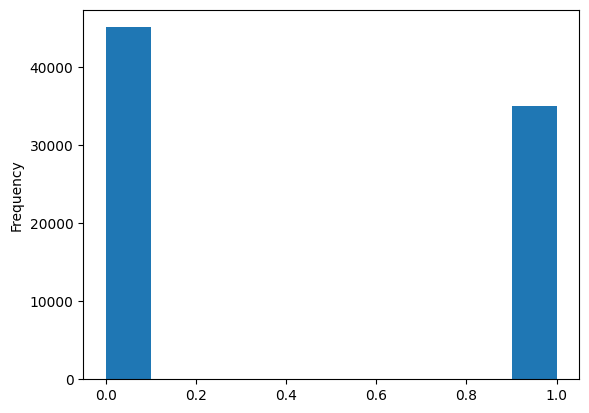

In [ ]:
# Positive count vs. negative count
train_df['relevance'].value_counts()
train_df_negatives = train_df['relevance'].value_counts()[0]
train_df_positives = train_df['relevance'].value_counts()[1]
print(f"Number of negatives: {train_df_negatives}")
print(f"Number of positives: {train_df_positives}")

# Check for missing values
missing_val_train = train_df.isnull().sum().sum()
missing_val_test = test_df.isnull().sum().sum()
print('Missing values in training data: ', missing_val_train)
print('Missing values in test data: ', missing_val_test)

# Histogram of positive vs. negative count
train_df['relevance'].astype(int).plot.hist()

**Setup**

In [ ]:
# Set random seed for reproducibility
random_seed = 12345
np.random.seed(random_seed)

# Specify initial features and target column
initial_features = ['query_length', 'is_homepage', 'sig1', 'sig2', 'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8']
target_column = 'relevance'

**Feature vs. Relevance Box Plots**

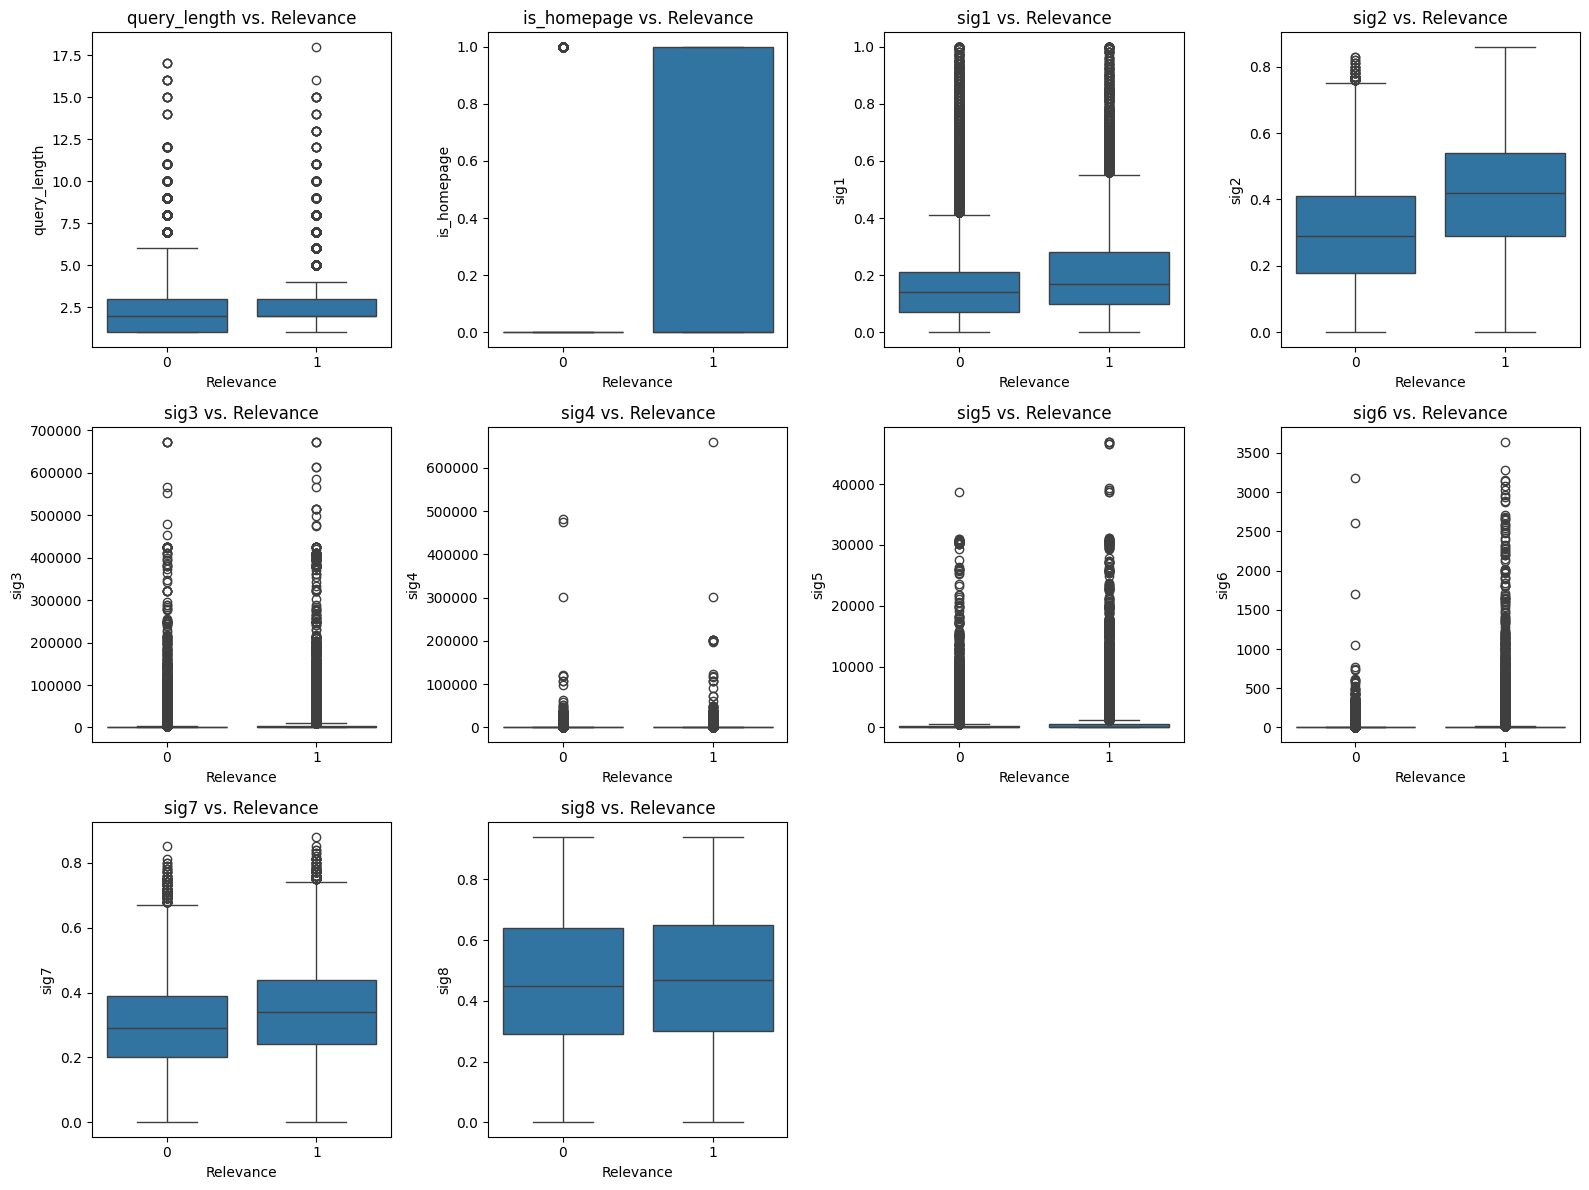

In [ ]:
# Determine the number of rows needed
num_features = len(initial_features)
num_columns = 4 # Plots per row
num_rows = (num_features + num_columns - 1) // num_columns  # Number of rows

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(4*num_columns, 4*num_rows))
axes = axes.flatten()

# Create a boxplot for each feature
for i, feature in enumerate(initial_features):
    sns.boxplot(x=train_df[target_column], y=train_df[feature], ax=axes[i])
    axes[i].set_title(f'{feature} vs. Relevance')
    axes[i].set_xlabel('Relevance')
    axes[i].set_ylabel(feature)

# Remove any unused subplots
for j in range(num_features, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show plot
plt.tight_layout()
plt.show()

**General Implications for Feature Engineering and Predictive Modeling:**

**Feature Importance:** Features like is_homepage, sig2, sig7, and sig8 show more promise and should be prioritized in model training.

**Transformation/Normalization:** Features with a large number of outliers (sig3, sig4, sig5, sig6) might benefit from transformations to reduce skewness and make the model more robust.

**Interaction Terms:** Consider exploring interaction terms between features like query_length and is_homepage to see if they provide additional predictive power.

**Feature Reduction:** Some features (sig1, sig3, sig4, sig5, sig6) show limited discriminatory power and might be candidates for exclusion or further analysis.

**Heatmap Correlation Matrix**

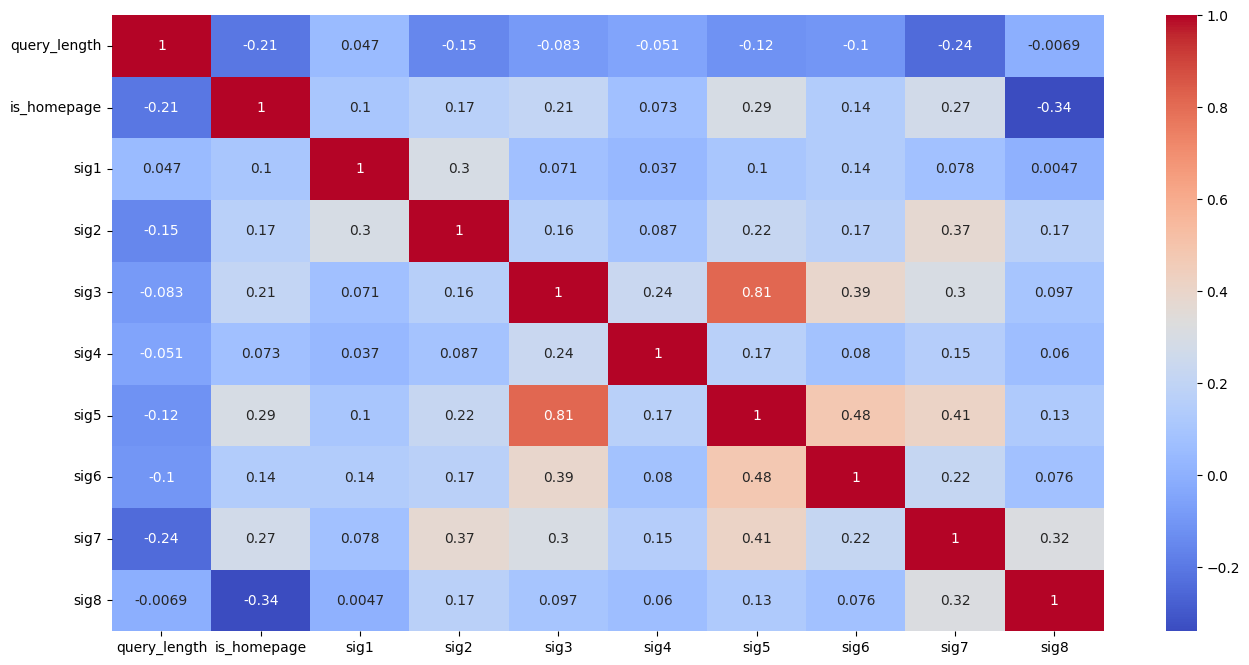

In [ ]:
# Heatmap Correlation Matrix
plt.figure(figsize=(16, 8))
correlation_matrix = train_df[initial_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

**Analysis and decisions**

Take out sig3 due to high correlation (0.81) with sig5.

Add interaction terms with:
*   is_homepage and sig5 (0.29)
*   is_homepage and sig7 (0.27)
*   is_homepage and sig8 (-.34)
*   sig2 and sig7 (0.37)
*   sig5 and sig6 (0.48)
*   sig5 and sig7 (0.41)
*   sig7 and sig8 (0.32)







**Add Interaction Terms**

In [ ]:
# Add interaction terms for training set
train_df['is_homepage_sig5'] = train_df['is_homepage'] * train_df['sig5']
train_df['is_homepage_sig7'] = train_df['is_homepage'] * train_df['sig7']
train_df['is_homepage_sig8'] = train_df['is_homepage'] * train_df['sig8']
train_df['sig2_sig7'] = train_df['sig2'] * train_df['sig7']
train_df['sig5_sig6'] = train_df['sig5'] * train_df['sig6']
train_df['sig5_sig7'] = train_df['sig5'] * train_df['sig7']
train_df['sig7_sig8'] = train_df['sig7'] * train_df['sig8']

In [ ]:
# Add interaction terms for test set
test_df['is_homepage_sig5'] = test_df['is_homepage'] * test_df['sig5']
test_df['is_homepage_sig7'] = test_df['is_homepage'] * test_df['sig7']
test_df['is_homepage_sig8'] = test_df['is_homepage'] * test_df['sig8']
test_df['sig2_sig7'] = test_df['sig2'] * test_df['sig7']
test_df['sig5_sig6'] = test_df['sig5'] * test_df['sig6']
test_df['sig5_sig7'] = test_df['sig5'] * test_df['sig7']
test_df['sig7_sig8'] = test_df['sig7'] * test_df['sig8']

**K-Means Clustering Feature**

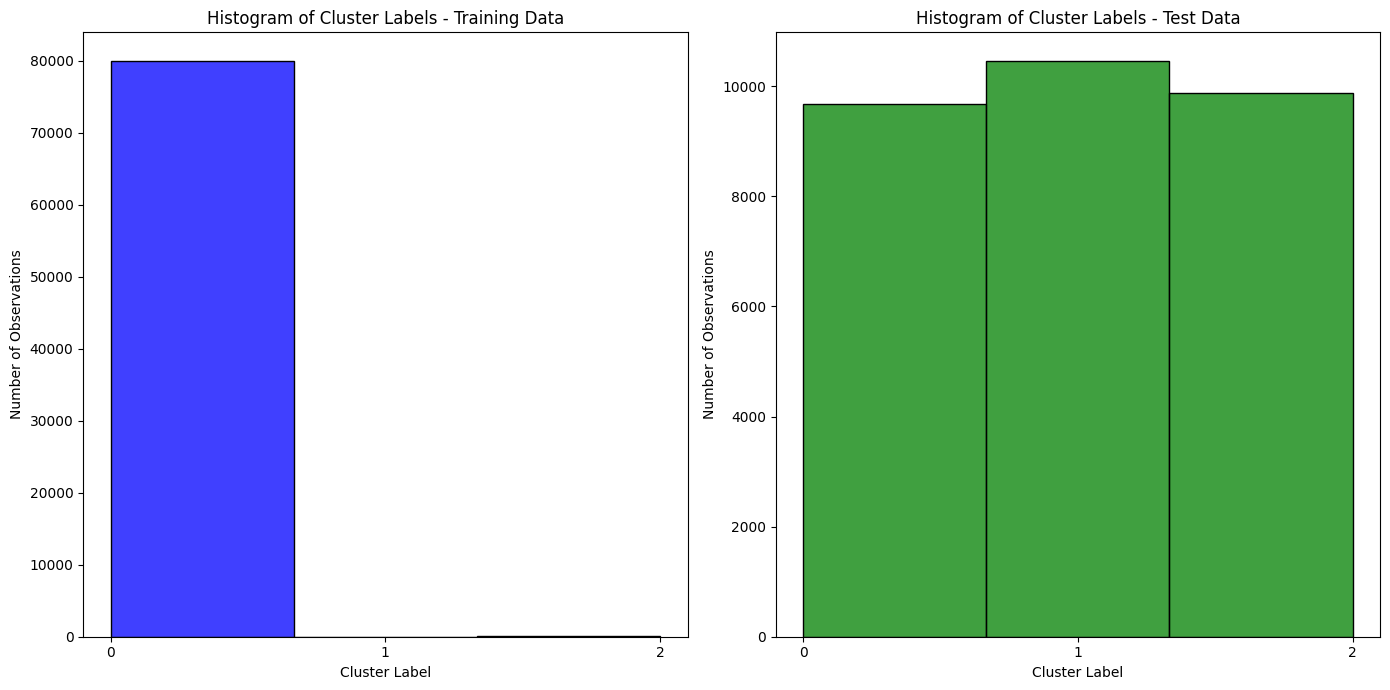

Number of observations in each cluster (Training Data):
cluster_label
0    79932
1       22
2       92
Name: count, dtype: int64
Number of observations in each cluster (Test Data):
cluster_label
0     9672
1    10456
2     9873
Name: count, dtype: int64


In [ ]:
# K-Means Clustering (K = 3)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed)

# Create cluster label feature for train and test set
train_df['cluster_label'] = kmeans.fit_predict(train_df)
test_df['cluster_label'] = kmeans.fit_predict(test_df)

# Histogram for training and test data cluster labels
plt.figure(figsize=(14, 7))

# Train cluster labels
plt.subplot(1, 2, 1)
sns.histplot(train_df['cluster_label'], kde=False, bins=n_clusters, color='blue')
plt.title('Histogram of Cluster Labels - Training Data')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Observations')
plt.xticks(ticks=[0, 1, 2])

# Test cluster labels
plt.subplot(1, 2, 2)
sns.histplot(test_df['cluster_label'], kde=False, bins=n_clusters, color='green')
plt.title('Histogram of Cluster Labels - Test Data')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Observations')
plt.xticks(ticks=[0, 1, 2])

# Adjust layout and display plot
plt.tight_layout()
plt.show()

# Count and print the number of observations in each cluster for training data
train_cluster_counts = train_df['cluster_label'].value_counts().sort_index()
print("Number of observations in each cluster (Training Data):")
print(train_cluster_counts)

# Count and print the number of observations in each cluster for test data
test_cluster_counts = test_df['cluster_label'].value_counts().sort_index()
print("Number of observations in each cluster (Test Data):")
print(test_cluster_counts)

**Outliers**

In [ ]:
# Get Z-scores for each feature on train and test set
z_scores_train = np.abs(stats.zscore(train_df))
z_scores_test = np.abs(stats.zscore(test_df))

# Define a threshold and get outliers
threshold = 3
outliers_z_train = np.where(z_scores_train > threshold)
outliers_z_test = np.where(z_scores_test > threshold)

# Print outliers
print(f"Outliers (train) detected using Z-score: {len(outliers_z_train[0])} data points")
print(f"Outliers (test) detected using Z-score: {len(outliers_z_test[0])} data points")

Outliers (train) detected using Z-score: 11482 data points
Outliers (test) detected using Z-score: 4554 data points


In [ ]:
# Apply capped transformation to reduce the impact of outliers on train and test set
train_df_capped = train_df.apply(lambda x: np.where(x > x.quantile(0.95), x.quantile(0.95), x))
train_df_capped = train_df_capped.apply(lambda x: np.where(x < x.quantile(0.05), x.quantile(0.05), x))

test_df_capped = test_df.apply(lambda x: np.where(x > x.quantile(0.95), x.quantile(0.95), x))
test_df_capped = test_df_capped.apply(lambda x: np.where(x < x.quantile(0.05), x.quantile(0.05), x))

**Outlier Transformation Histogram Comparison**

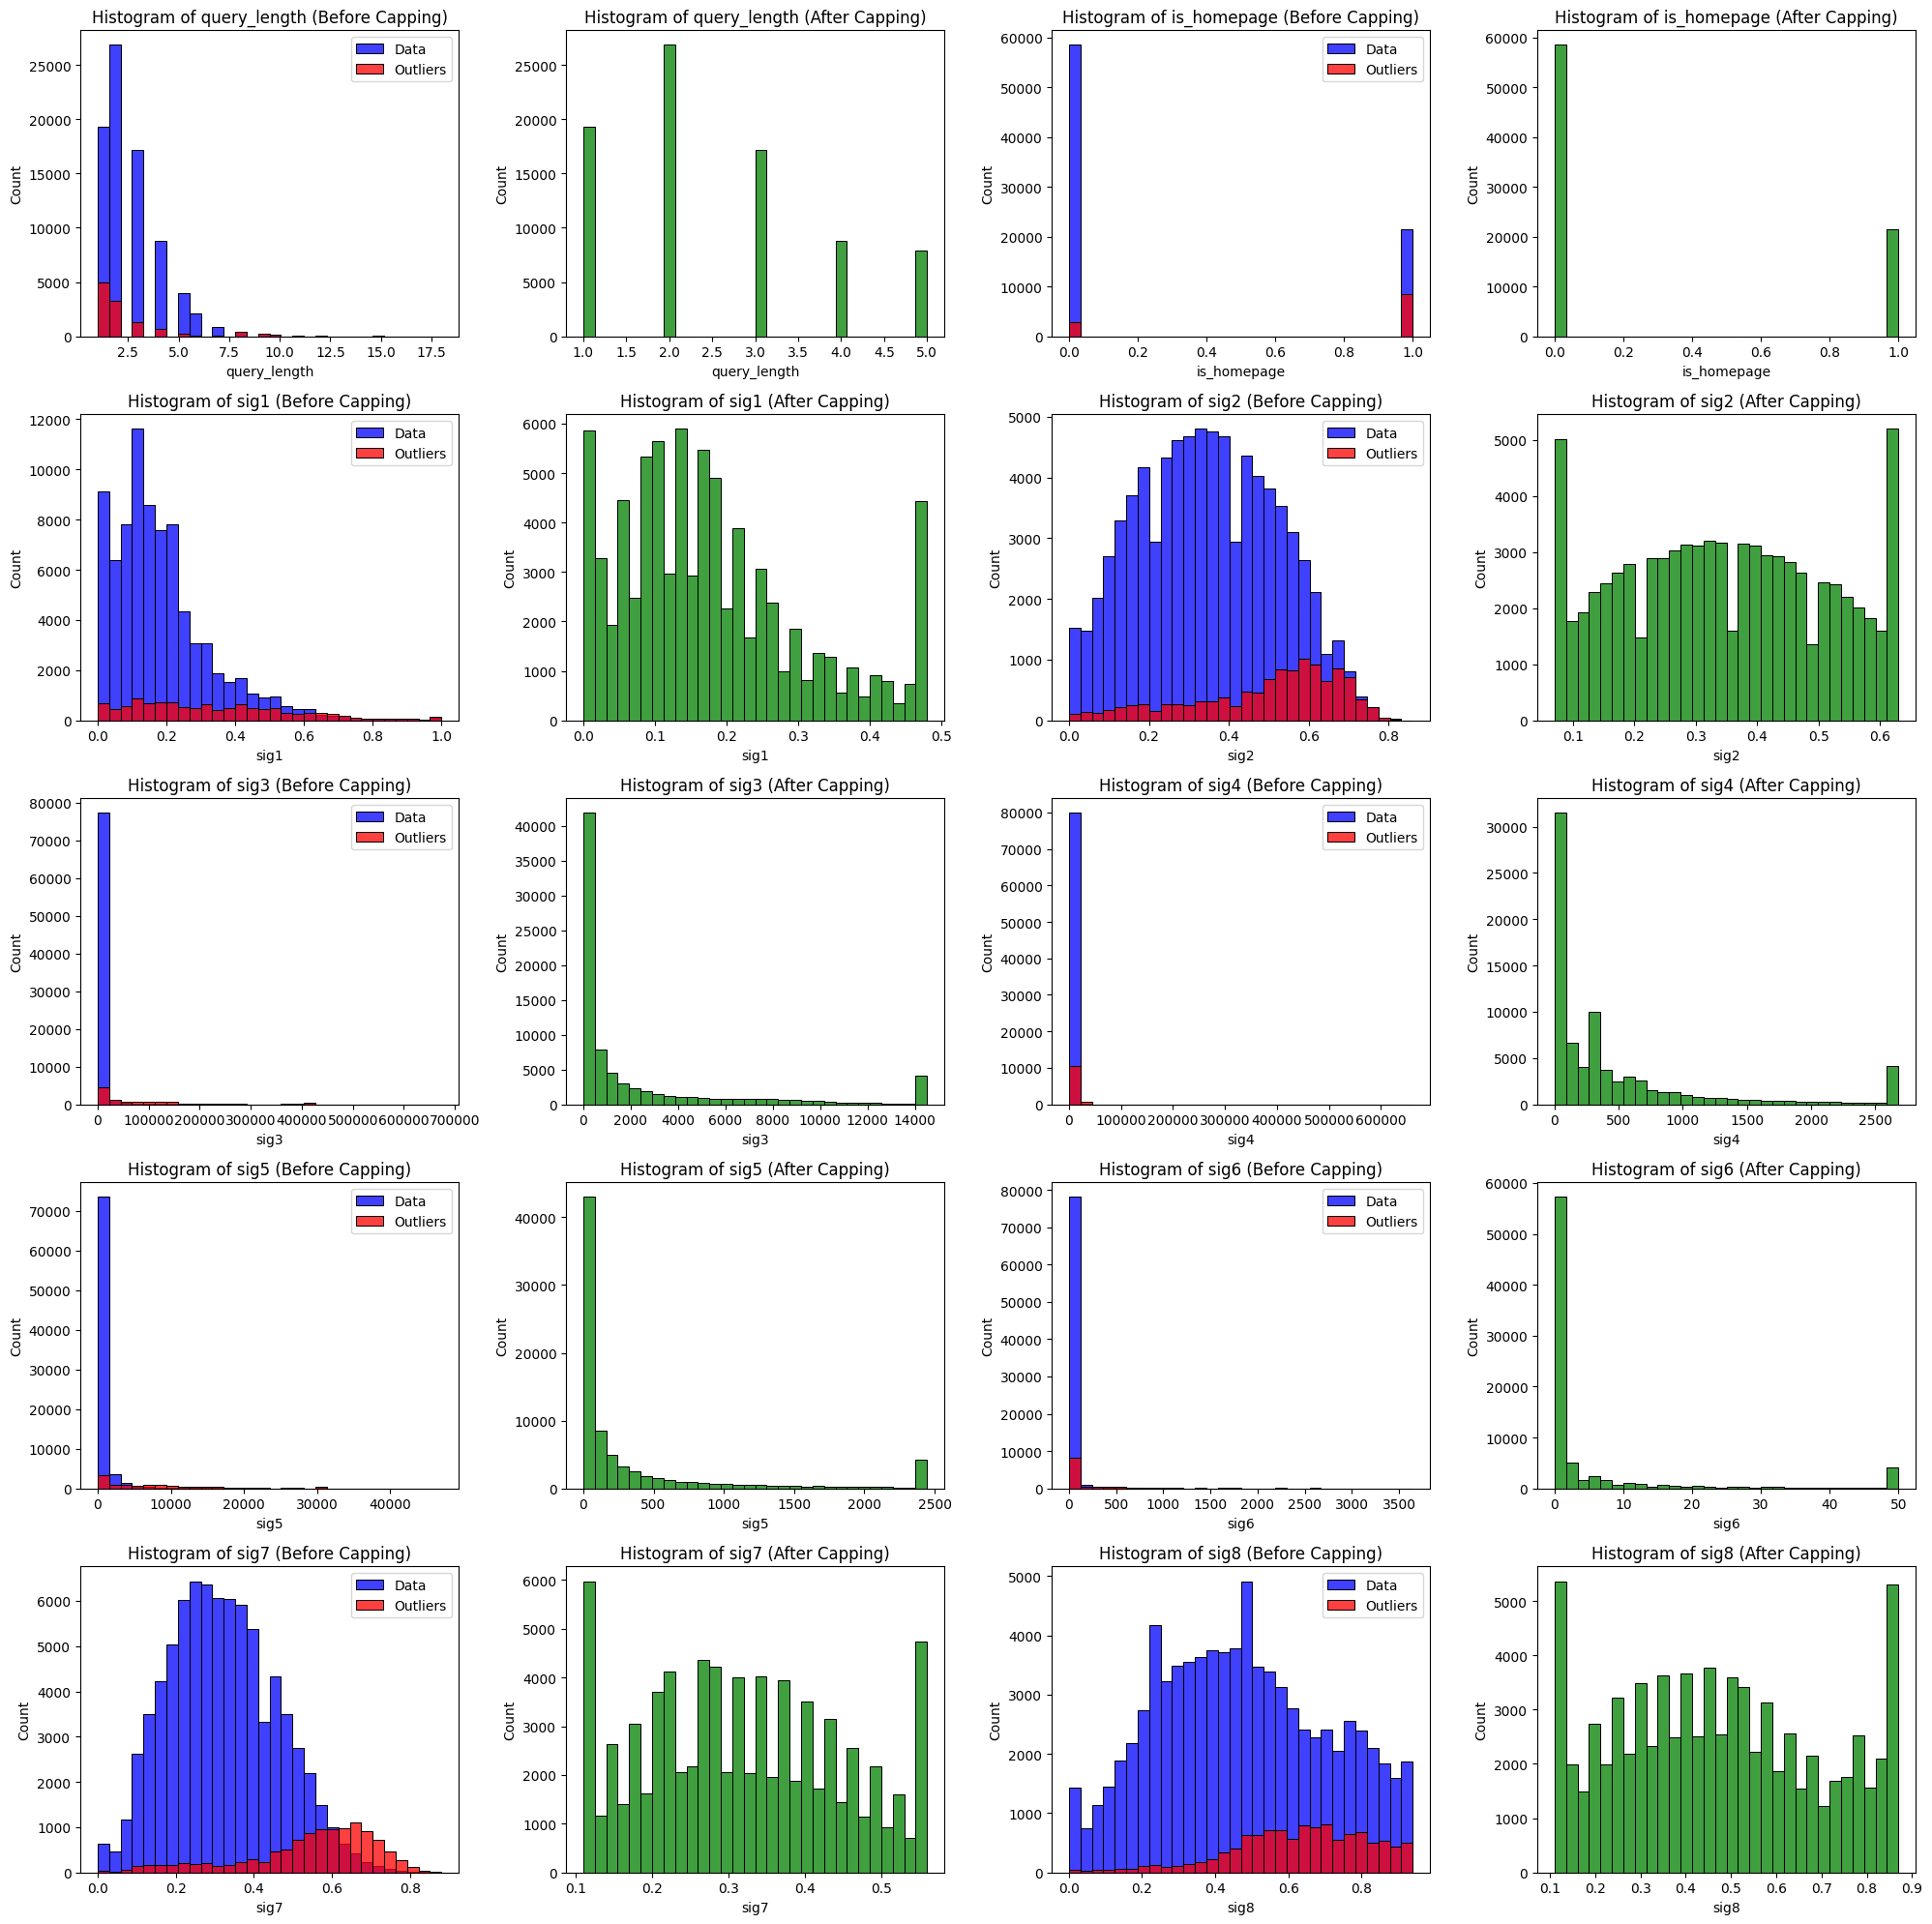

In [ ]:
# Train data numeric and capped
train_df_numeric = train_df.drop(columns=['query_id', 'url_id', 'id', 'relevance'])
train_df_capped_numeric = pd.DataFrame(train_df_capped, columns=train_df_numeric.columns)

# Determine the number of features
features = train_df.drop(columns=['query_id', 'url_id', 'id', 'relevance']).columns
num_features = len(features)
num_columns = 4  # Two pairs of histograms per row
num_rows = (num_features + num_columns - 1) // num_columns  # Number of rows

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(5*num_columns, 4*num_rows))
axes = axes.flatten()

# Create histograms for each feature
for i, feature in enumerate(features):
    if 2*i < len(axes):
        # Histogram before capping with outliers highlighted
        sns.histplot(train_df_numeric[feature], bins=30, color='blue', ax=axes[2*i], label='Data')
        sns.histplot(train_df_numeric.iloc[outliers_z_train[0]][feature], bins=30, kde=False, color='red', ax=axes[2*i], label='Outliers')
        axes[2*i].set_title(f'Histogram of {feature} (Before Capping)')
        axes[2*i].set_xlabel(feature)
        axes[2*i].set_ylabel('Count')
        axes[2*i].legend()

    if 2*i + 1 < len(axes):
        # Histogram after capping
        sns.histplot(train_df_capped_numeric[feature], bins=30, color='green', ax=axes[2*i+1], label='Capped Data')
        axes[2*i+1].set_title(f'Histogram of {feature} (After Capping)')
        axes[2*i+1].set_xlabel(feature)
        axes[2*i+1].set_ylabel('Count')

# Remove any unused subplots
for j in range(2*num_features, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show plot
plt.tight_layout()
plt.show()

**Final Predictors and Target**

In [ ]:
# Specify predictors and target
X_train = train_df_capped.drop(columns=['query_id', 'url_id', 'id', 'relevance'])
y_train = train_df_capped['relevance']
X_test = test_df_capped.drop(columns=['query_id', 'url_id', 'id'])

# Standardize the features
X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

# Track model scores
model_scores = {
    'Logistic Regression': [],
    'LDA': [],
    'Gradient Boosting': [],
    'Neural Network': []
}

# **Logistic Regression Model**

In [ ]:
# Initialize Logistic Regression model
logistic_regression_model = LogisticRegression(
    penalty='l2',  # Use L2 (Ridge) regularization to penalize large coefficients to prevent overfitting
    C=1,  # Controls regularization strength: 1 = moderate regularization
    solver='lbfgs',  # Optimization algorithm: 'lbfgs', efficient for smaller datasets and suitable for L2 regularization
    max_iter=1000,  # Sets the maximum number of iterations the solver will take to converge.
    random_state=random_seed,  # Random seed ensures reproducibility of the results
    n_jobs=-1  # Allows for parallel computation: -1 = use all processors
)

# Use 5-fold cross-validation to evaluate the model
cv_scores_logreg = cross_val_score(logistic_regression_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
model_scores['Logistic Regression'] = cv_scores_logreg

# Print results of cross-validation
print(f"Cross-validation scores: {cv_scores_logreg}")
print(f"Average cross-validation score: {np.mean(cv_scores_logreg)}")

Cross-validation scores: [0.66102436 0.65625586 0.65394466 0.65719283 0.65987882]
Average cross-validation score: 0.6576593038370945


# **Linear Discriminant Analysis (LDA) Model**

In [ ]:
# Initialize LDA model
lda_model = LinearDiscriminantAnalysis(
    solver='svd',             # Solver (method used for discriminant analysis): 'svd' is default and works with most datasets
    tol=1e-4                  # Threshold used for rank estimation in 'svd' solver
)

# Use 5-fold cross-validation to evaluate the model
cv_scores_lda = cross_val_score(lda_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
model_scores['LDA'] = cv_scores_lda

# Print results of cross-validation
print(f"Cross-validation scores: {cv_scores_lda}")
print(f"Average cross-validation score: {np.mean(cv_scores_lda)}")

Cross-validation scores: [0.66202374 0.6570679  0.65406959 0.65744269 0.66031607]
Average cross-validation score: 0.6581839962054449


# **Gradient Boosting Classifier Model**

In [ ]:
# Initialize Gradient Boosting classifier
gradient_boosting_model = GradientBoostingClassifier(
    n_estimators=200,        # Number of trees to be run: 200 = balanced, sufficient learning without overfitting
    learning_rate=0.1,       # Learning rate: 0.1 = accelerates learning process, but each tree's impact is larger, potentially leading to overfitting
    max_depth=3,             # Maximum depth of each individual tree: shallower trees (depth = 3) reduce model complexity, helping to prevent overfitting
    subsample=1,             # Fraction of samples used to fit each tree: 1 = entire dataset is used for each tree
    max_features='sqrt',     # Number of features to consider when looking for the best split: square root helps in reducing variance and overfitting
    random_state=random_seed # Random seed ensures reproducibility of the results
)

# Use 5-fold cross-validation to evaluate the model
cv_scores_gb = cross_val_score(gradient_boosting_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
model_scores['Gradient Boosting'] = cv_scores_gb

# Print results of cross-validation
print(f"Cross-validation scores: {cv_scores_gb}")
print(f"Average cross-validation score: {np.mean(cv_scores_gb)}")

Cross-validation scores: [0.67226733 0.66268974 0.66031607 0.66668749 0.66849897]
Average cross-validation score: 0.6660919199533648


# **Neural Network (MLP Classifier) Model**

In [ ]:
# Initialize MLP Classifier model
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100,),  # Structure of the hidden layers: (100,) = single hidden layer with 100 neurons
    activation='logistic',      # Activation function for the hidden layers: 'logistic' = sigmoid function (0 to 1)
    solver='adam',              # Solver for weight optimization: 'adam' = adaptive learning rate optimization algorithm
    alpha=0.0001,               # L2 regularization term (alpha): revents overfitting by penalizing large weights, encouraging the model to prefer smaller weights
    max_iter=200,               # Maximum number of iterations
    random_state=random_seed,   # Random seed ensures reproducibility of the results
    tol=1e-5,                   # Tolerance for the optimization: smaller = more thorough optimization
    learning_rate_init=0.001,   # Initial learning rate: starting step size for the optimization
    early_stopping=True,        # Early stopping: stops training when validation performance stops improving
    validation_fraction=0.1,    # Fraction of training data used for validation: 0.1 = 10% of the training data to validate the model during training
    verbose=True                # True = model will output progress messages during training
)

# Use 5-fold cross-validation to evaluate the model
cv_scores_mlp = cross_val_score(mlp_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
model_scores['Neural Network'] = cv_scores_mlp

# Print results of cross-validation
print(f"Cross-validation scores: {cv_scores_mlp}")
print(f"Average cross-validation score: {np.mean(cv_scores_mlp)}")

Iteration 1, loss = 0.63464548
Validation score: 0.655840
Iteration 2, loss = 0.62077901
Validation score: 0.653186
Iteration 3, loss = 0.62013466
Validation score: 0.656621
Iteration 4, loss = 0.61980159
Validation score: 0.655215
Iteration 5, loss = 0.61982799
Validation score: 0.653029
Iteration 6, loss = 0.61942394
Validation score: 0.654903
Iteration 7, loss = 0.61956952
Validation score: 0.656621
Iteration 8, loss = 0.61902028
Validation score: 0.654591
Iteration 9, loss = 0.61928333
Validation score: 0.655684
Iteration 10, loss = 0.61904316
Validation score: 0.655528
Iteration 11, loss = 0.61904787
Validation score: 0.655215
Iteration 12, loss = 0.61911105
Validation score: 0.658339
Iteration 13, loss = 0.61898470
Validation score: 0.654122
Iteration 14, loss = 0.61871257
Validation score: 0.654435
Iteration 15, loss = 0.61870583
Validation score: 0.657245
Iteration 16, loss = 0.61838411
Validation score: 0.654747
Iteration 17, loss = 0.61822141
Validation score: 0.654903
Iterat

# **Visualization of Models Performances**

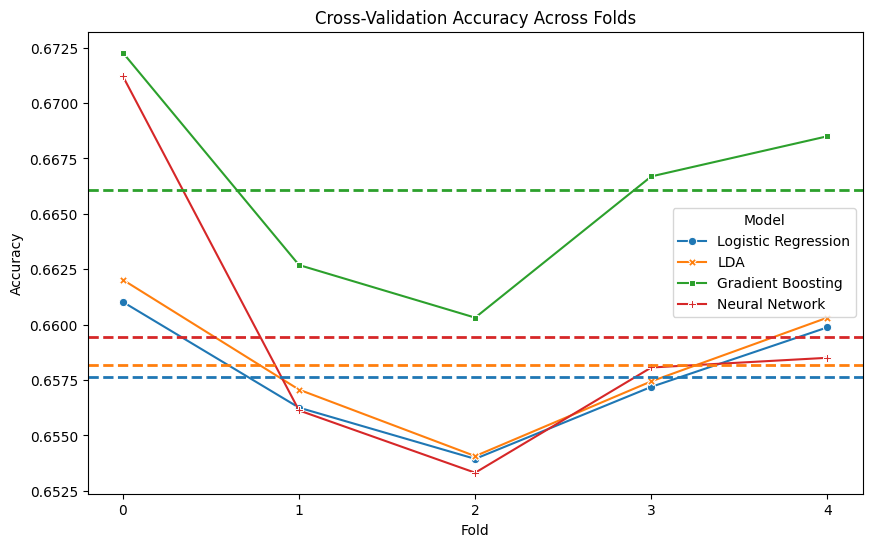

In [ ]:
# Create dataframe for comparison
scores_df = pd.DataFrame(model_scores)

# Line plot of CV scores
plt.figure(figsize=(10, 6))
sns.lineplot(data=scores_df, markers=True, dashes=False)

# Plot horizontal lines for average scores
for i, model in enumerate(scores_df.columns):
    avg_score = scores_df[model].mean()
    plt.axhline(y=avg_score, linestyle='--', linewidth=2, color=sns.color_palette()[i])

plt.title('Cross-Validation Accuracy Across Folds')
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.xticks([0,1,2,3,4])
plt.legend(title='Model')
plt.show()

# **Prediction Text File Output**

In [ ]:
# Fit the best model (Gradient Boosting classifier) on the training set
gradient_boosting_model.fit(X_train_scaled, y_train)

# Make predictions on test set
predictions = gradient_boosting_model.predict(X_test_scaled)

ids = test_df['id']

# Create a DataFrame with 'id' and 'relevance' columns
output_df = pd.DataFrame({
    'id': ids,
    'relevance': predictions
})

# Save the predictions to a CSV file
output_file = './predictions.csv'
output_df.to_csv(output_file, index=False)

print(f'Predictions saved to {output_file}')